# TOI-216: Two-planet TTV fit 

In [1]:
from CONAN.get_files import get_TESS_data, get_parameters
import numpy as np
import matplotlib.pyplot as plt
import CONAN
CONAN.__version__

'3.3.11'

We will analyse the TESS data of TOI-216 as published in [Kipping et. al 2019](https://academic.oup.com/mnras/article/486/4/4980/5488441?login=false). 

## Data download

In [2]:
df = get_TESS_data("TOI-216")
df.search(sectors=[1,2,3,4,5,6], author="SPOC") 

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120    55652896      0.0
  1 TESS Sector 02 2018   SPOC     120    55652896      0.0
  2 TESS Sector 03 2018   SPOC     120    55652896      0.0
  3 TESS Sector 04 2018   SPOC     120    55652896      0.0
  4 TESS Sector 05 2018   SPOC     120    55652896      0.0
  5 TESS Sector 06 2018   SPOC     120    55652896      0.0


In [ ]:
df.download(sectors=[1,2,3,4,5,6],author="SPOC", select_flux="pdcsap_flux",
            quality_bitmask='hardest')

# df.scatter()

In [ ]:
df.save_CONAN_lcfile(bjd_ref = 2457000, folder="data")

saved file as: TOI-216/TOI-216_S1.dat
saved file as: TOI-216/TOI-216_S2.dat
saved file as: TOI-216/TOI-216_S3.dat
saved file as: TOI-216/TOI-216_S4.dat
saved file as: TOI-216/TOI-216_S5.dat
saved file as: TOI-216/TOI-216_S6.dat


## Data Analysis

In [3]:
from glob import glob
from os.path import basename
lcs = glob("data/TOI*")
lc_list = [basename(lc) for lc in lcs]
lc_list

['TOI-216_S1.dat',
 'TOI-216_S2.dat',
 'TOI-216_S3.dat',
 'TOI-216_S6.dat',
 'TOI-216_S4.dat',
 'TOI-216_S5.dat']

In [4]:
lc_obj = CONAN.load_lightcurves(   file_list     = lc_list,
                                    data_filepath = "data/",
                                    nplanet       = 2)
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name           flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
TOI-216_S1.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           
TOI-216_S2.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    2 n  None           
TOI-216_S3.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    3 n  None           
TOI-216_S6.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    4 n  None           
TOI-216_S4.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    5 n  None           
TOI-216_S5.dat V   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    6 n  None           


lightcurves from filepath: data/
2 transiting planet(s)
Order of unique filters: ['V']

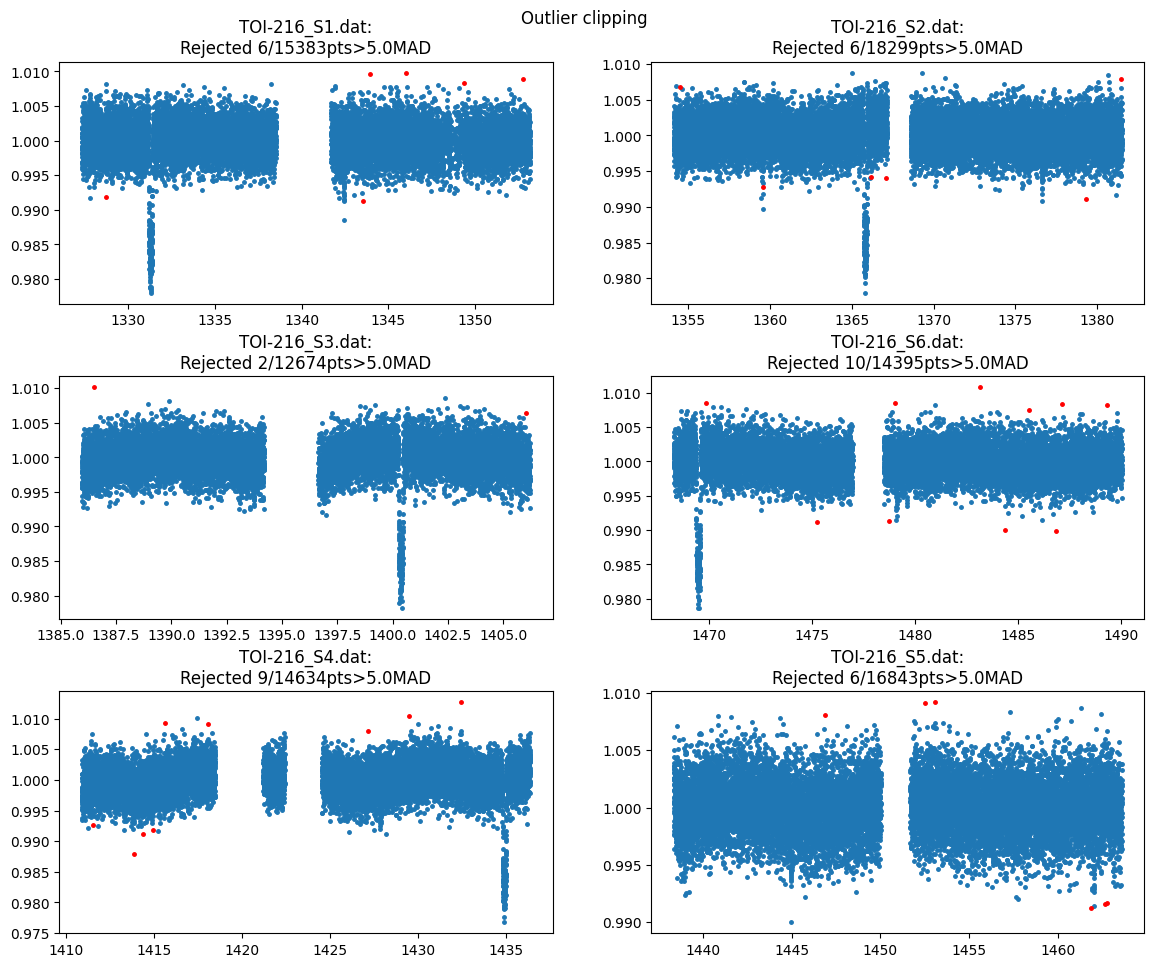

In [5]:
lc_obj.clip_outliers(niter=3,show_plot=True)

For multiplanet system, the transit model has to be parameterized by `rho_star` to reduce the number of free paramters (as opposed to fitting `Duration` for each planet's transit)

For TTV fit, we need to fix **T_0** and **Period** for the planets 

In [6]:
lc_obj.planet_parameters(rho_star    = (2.38, 0.1),
                         RpRs        = [(0.05,0.1,0.15),    #planet b
                                        (0.05,0.1,0.15)],   #planet c
                         Period      = [17.089,             #planet b
                                        34.556],            #planet c
                         T_0         = [1342.42819461 ,     #planet b
                                        1331.28531],        #planet c
                         Impact_para = [(0.5,0.948,1.2),    #planet b
                                        (0,0.15,0.5)]       #planet c
                        )

lc_obj.limb_darkening(  q1  =   (0,0.44,1), 
                        q2  =   (0,0.24,1)
                    )

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        y   	N(2.38,0.1)                        	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs_1                     y   	U(0.05,0.1,0.15)                   	#range[-0.5,0.5]
Impact_para_1              y   	U(0.5,0.948,1.2)                   	#range[0,2]
T_0_1                      n   	F(1342.42819461)                   	#unit(days)
Period_1                   n   	F(17.089)                          	#range[0,inf]days
[Eccentricity_1]/sesinw_1  n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega_1]/secosw_1         n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K_1                        n   	F(0)      

calling the `.transit_timing_variation()` function with `ttvs='y'` uses the **T_0** and **Period** values set in `.planet_parameters()` to search for transits in the data assuming a linear ephemeris. 

The `print_linear_eph` and `show_plot` arguments provides a print out and plot of the identified linear ephemeris transit times. The shaded region in the plot is the `baseline_amount` around each identified transit.

`dt` is the prior that defines the extent of deviation from linear ephemeris for each transit. Default is **U(-0.1,0,0.1)** indicating a uniform prior ranging between 2.4hrs before and after the expected linear ephemeris transit. **N(0,0.1)** is a normal prior around the expected transit time

# ============ TTV setup ========================================================================================
Fit_TTVs	dt_priors(deviation from linear T0)	transit_baseline[P]	per_LC_T0 	include_partial
y       	U(-0.1,0,0.1)                      	             0.0700	False     	True

======(linear ephemeris estimate)===============
label               	T0s (ordered)   	T0s priors
ttv00-lc1-T0_pl2    	1331.28531000	U(1331.1853,1331.2853,1331.3853)
ttv01-lc1-T0_pl1    	1342.42819461	U(1342.3282,1342.4282,1342.5282)
ttv02-lc2-T0_pl1    	1359.51719461	U(1359.4172,1359.5172,1359.6172)
ttv03-lc2-T0_pl2    	1365.84131000	U(1365.7413,1365.8413,1365.9413)
ttv04-lc2-T0_pl1    	1376.60619461	U(1376.5062,1376.6062,1376.7062)
ttv05-lc3-T0_pl1    	1393.69519461	U(1393.5952,1393.6952,1393.7952)
ttv06-lc3-T0_pl2    	1400.39731000	U(1400.2973,1400.3973,1400.4973)
ttv07-lc4-T0_pl2    	1469.50931000	U(1469.4093,1469.5093,1469.6093)
ttv08-lc4-T0_pl1    	1479.14019461	U(1479.0402,1479.1402,1479.2402)
tt

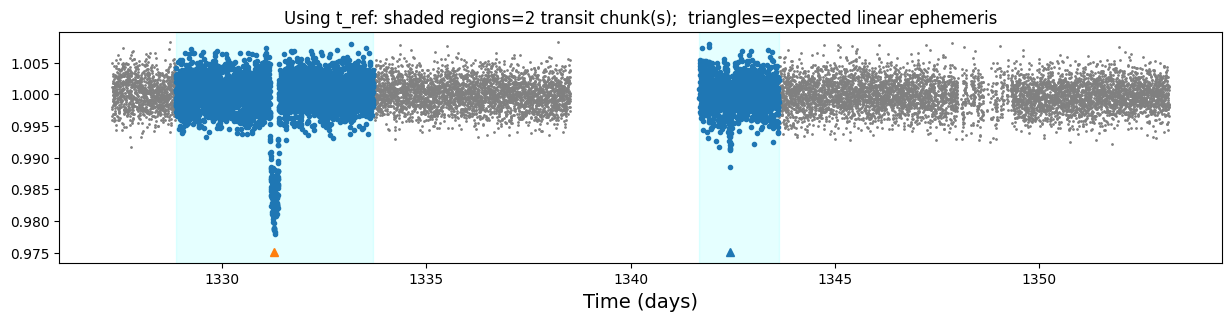

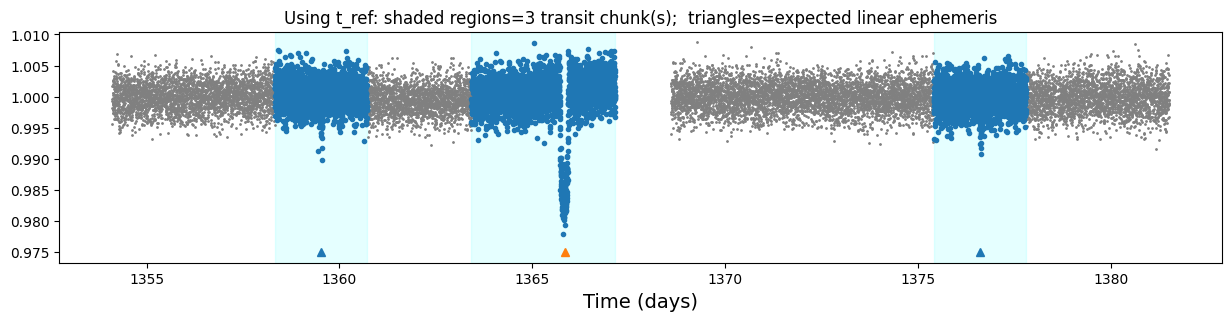

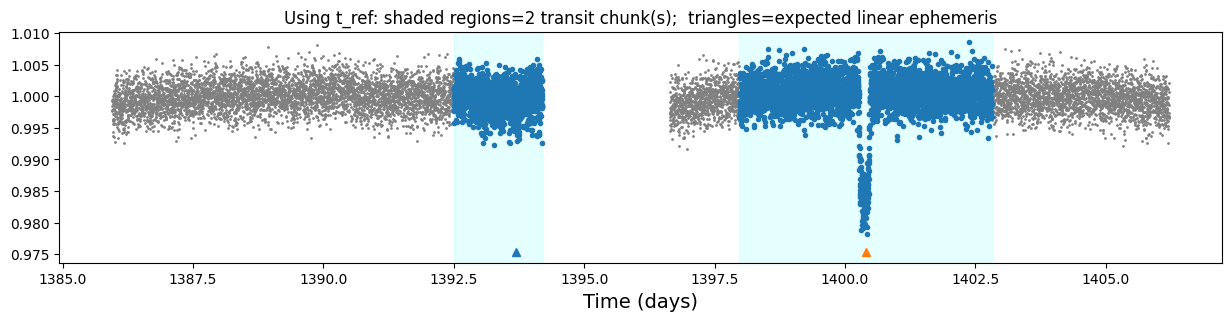

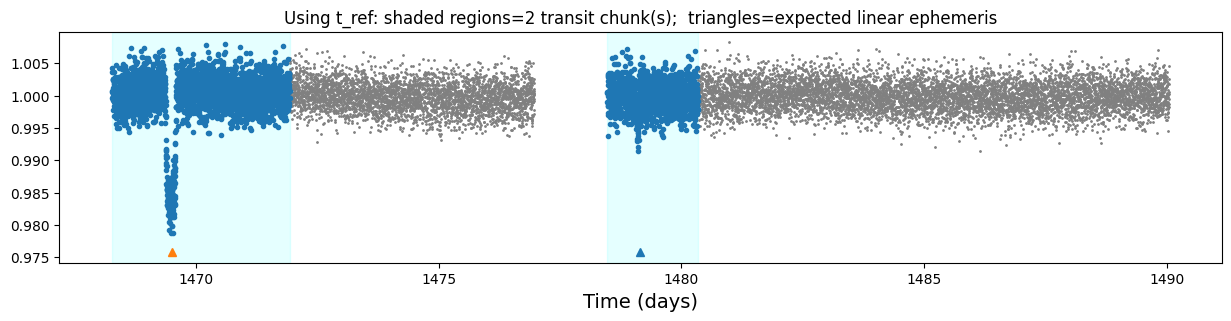

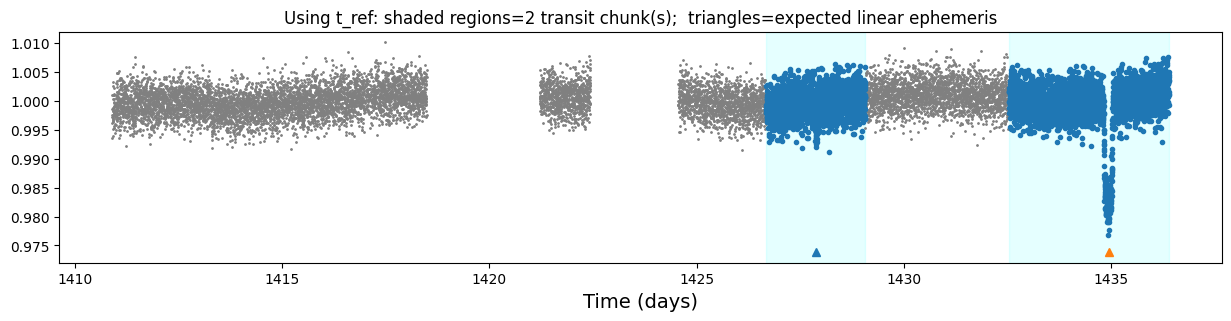

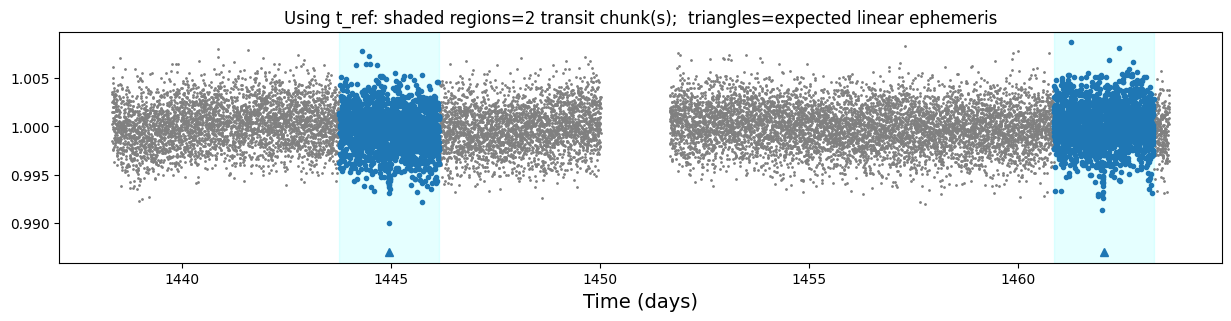

In [7]:
lc_obj.transit_timing_variation(ttvs            = "y", 
                                dt              = (-0.1, 0, 0.1), 
                                baseline_amount = 0.07,
                                show_plot       = True, 
                                print_linear_eph= True)

model the trend in the data using a GP

In [8]:
lc_obj.add_GP(  lc_list     = "same",
                par         = "col0",
                kernel      = 'mat32',
                amplitude   = (1,2000,4000),  #in ppm
                lengthscale = (0.1,1,30),     #in days
                gp_pck      = "ce"
                )

# ============ Input lightcurves, filters baseline function =======================================================
name           flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
TOI-216_S1.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    1 ce None           
TOI-216_S2.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    2 ce None           
TOI-216_S3.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    3 ce None           
TOI-216_S6.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    4 ce None           
TOI-216_S4.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    5 ce None           
TOI-216_S5.dat V   0.6  |None c1:W15C5n3   None    |  n    0    0    0    0    0    0    0|n    6 ce None           
# ============ Photometry GP properties (start newline with name 

detrending the data with a GP automatically sets offset = `n` to avoid correlations with the GP parameters. we can choose here to set it back to "y" for all lcs.

In [9]:
lc_obj._fit_offset = ["y"]*lc_obj._nphot

In [10]:
fit_obj = CONAN.fit_setup(apply_LCjitter="y")
fit_obj.sampling(n_cpus=10,n_live=150)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1,None)
Mass_[Msun]    N(None,None)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    150 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])         

### save config file

In [ ]:
CONAN.create_configfile(lc_obj=lc_obj, rv_obj=None, fit_obj=fit_obj,
                            filename='TOI216_ttvconfig.dat')

if config file already saved, the entire setup in the previous cells can be loaded with the following command


In [12]:
import CONAN
lc_obj, rv_obj, fit_obj = CONAN.load_configfile('TOI216_ttvconfig.dat')

#remember to put back the offsets if required
lc_obj._fit_offset = ["y"]*lc_obj._nphot

### Sampling

In [ ]:
result = CONAN.run_fit(lc_obj      = lc_obj,
                        rv_obj      = None,
                        fit_obj     = fit_obj, 
                        out_folder  = "result_TOI216", 
                        rerun_result= True)

## Load result of a previous run

In [14]:
import CONAN
import matplotlib.pyplot as plt
import numpy as np
result = CONAN.load_result("result_TOI216")

['lc'] Output files, ['TOI-216_S1_lcout.dat', 'TOI-216_S2_lcout.dat', 'TOI-216_S3_lcout.dat', 'TOI-216_S4_lcout.dat', 'TOI-216_S5_lcout.dat', 'TOI-216_S6_lcout.dat'], loaded into result object
['rv'] Output files, [], loaded into result object


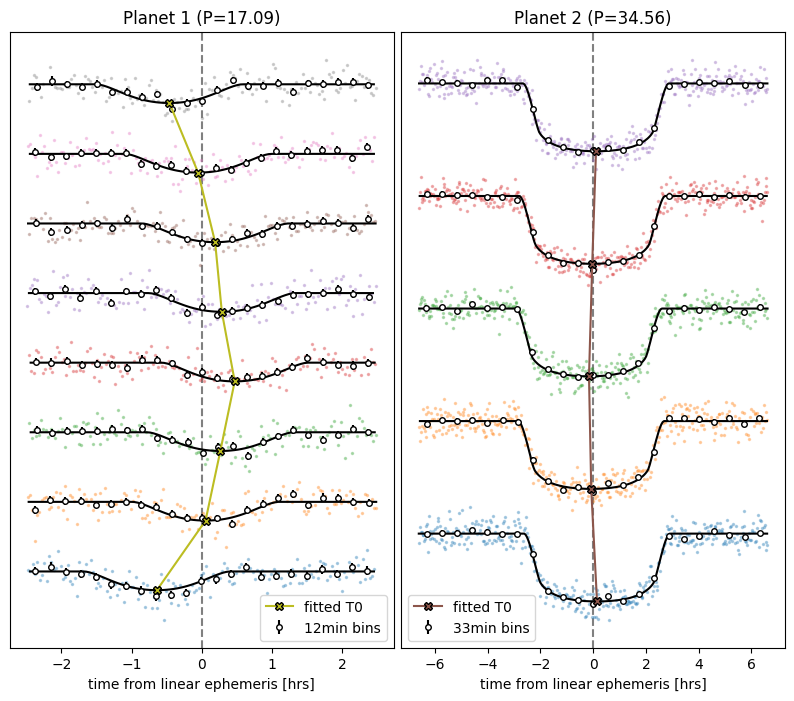

In [16]:
result.lc.plot_lcttv();

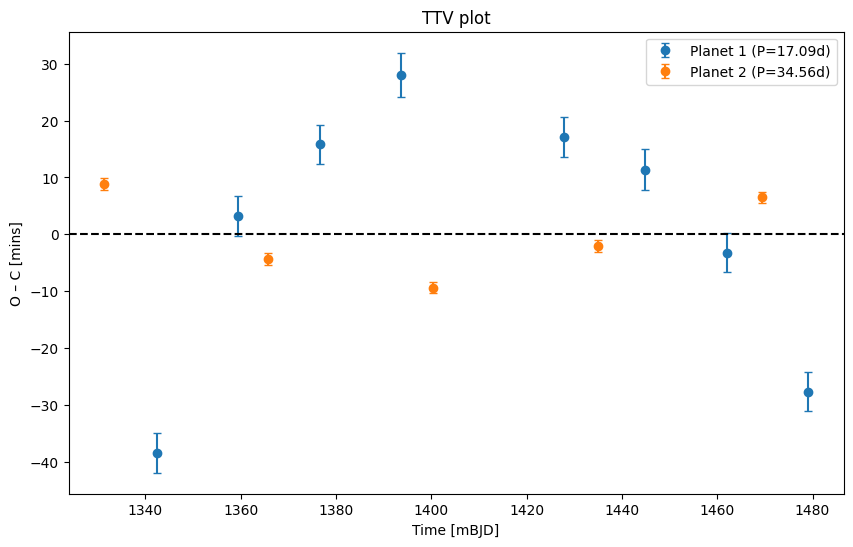

In [17]:
result.lc.plot_ttv();

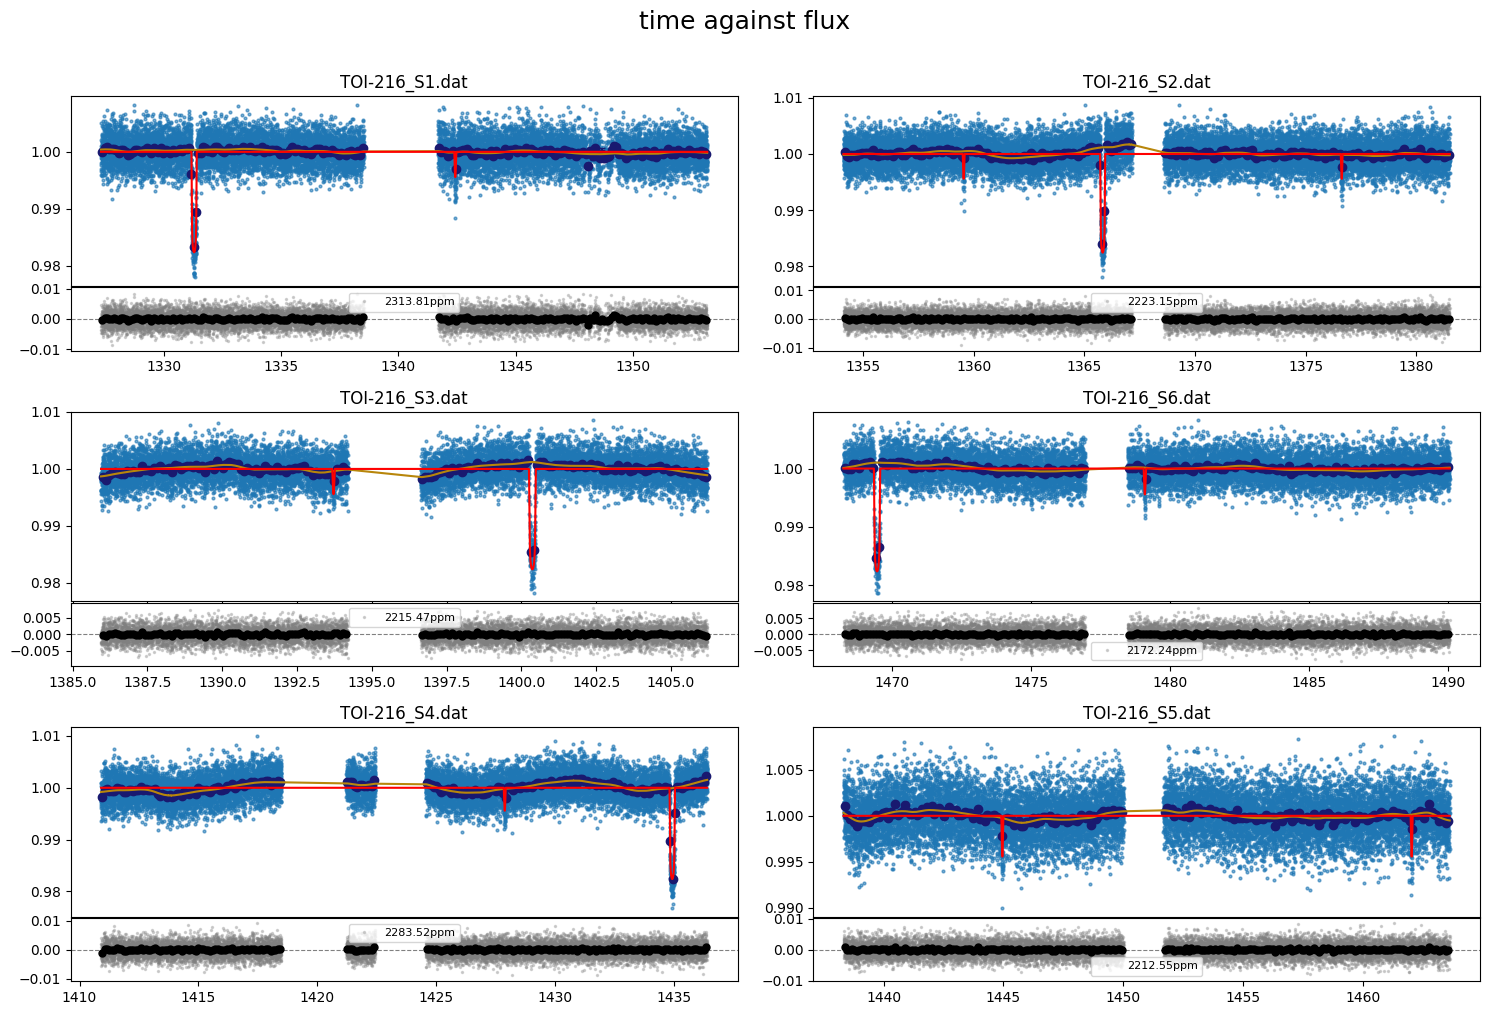

In [18]:
result.lc.plot_bestfit(figsize=(15,10),binsize=0.1);

In [19]:
# all varying parameters from the fit
params_dict = result.params_dict

In [20]:
#extract all ttv values
{k:v for k,v in params_dict.items() if f'ttv' in k}

{'ttv00-lc1-T0_pl2': 1331.2853585351754+/-0.000708561902342808,
 'ttv01-lc1-T0_pl1': 1342.4281946095093+/-0.0024361019883372137,
 'ttv02-lc2-T0_pl1': 1359.5394262797838+/-0.0024319350051200672,
 'ttv03-lc2-T0_pl2': 1365.824496367836+/-0.0007073555550505262,
 'ttv04-lc2-T0_pl1': 1376.630536387638+/-0.002353434384758657,
 'ttv05-lc3-T0_pl1': 1393.7214028843155+/-0.002681758582752991,
 'ttv06-lc3-T0_pl2': 1400.3692862108767+/-0.0006903885439442092,
 'ttv07-lc4-T0_pl2': 1469.4769257299806+/-0.0006485664398496738,
 'ttv08-lc4-T0_pl1': 1479.094324828132+/-0.002385498113653739,
 'ttv09-lc5-T0_pl1': 1427.8784160519003+/-0.002466846340325901,
 'ttv10-lc5-T0_pl2': 1434.9226946540493+/-0.000681746821555862,
 'ttv11-lc6-T0_pl1': 1444.9567796400843+/-0.002506038005321898,
 'ttv12-lc6-T0_pl1': 1462.029002832283+/-0.0024252965312143715}

In [21]:
#names of all transit time parameters
import numpy as np
all_T0_names = [nm for nm in result.params.names if 'ttv' in nm]
print(np.array(all_T0_names))

['ttv00-lc1-T0_pl2' 'ttv01-lc1-T0_pl1' 'ttv02-lc2-T0_pl1'
 'ttv03-lc2-T0_pl2' 'ttv04-lc2-T0_pl1' 'ttv05-lc3-T0_pl1'
 'ttv06-lc3-T0_pl2' 'ttv07-lc4-T0_pl2' 'ttv08-lc4-T0_pl1'
 'ttv09-lc5-T0_pl1' 'ttv10-lc5-T0_pl2' 'ttv11-lc6-T0_pl1'
 'ttv12-lc6-T0_pl1']


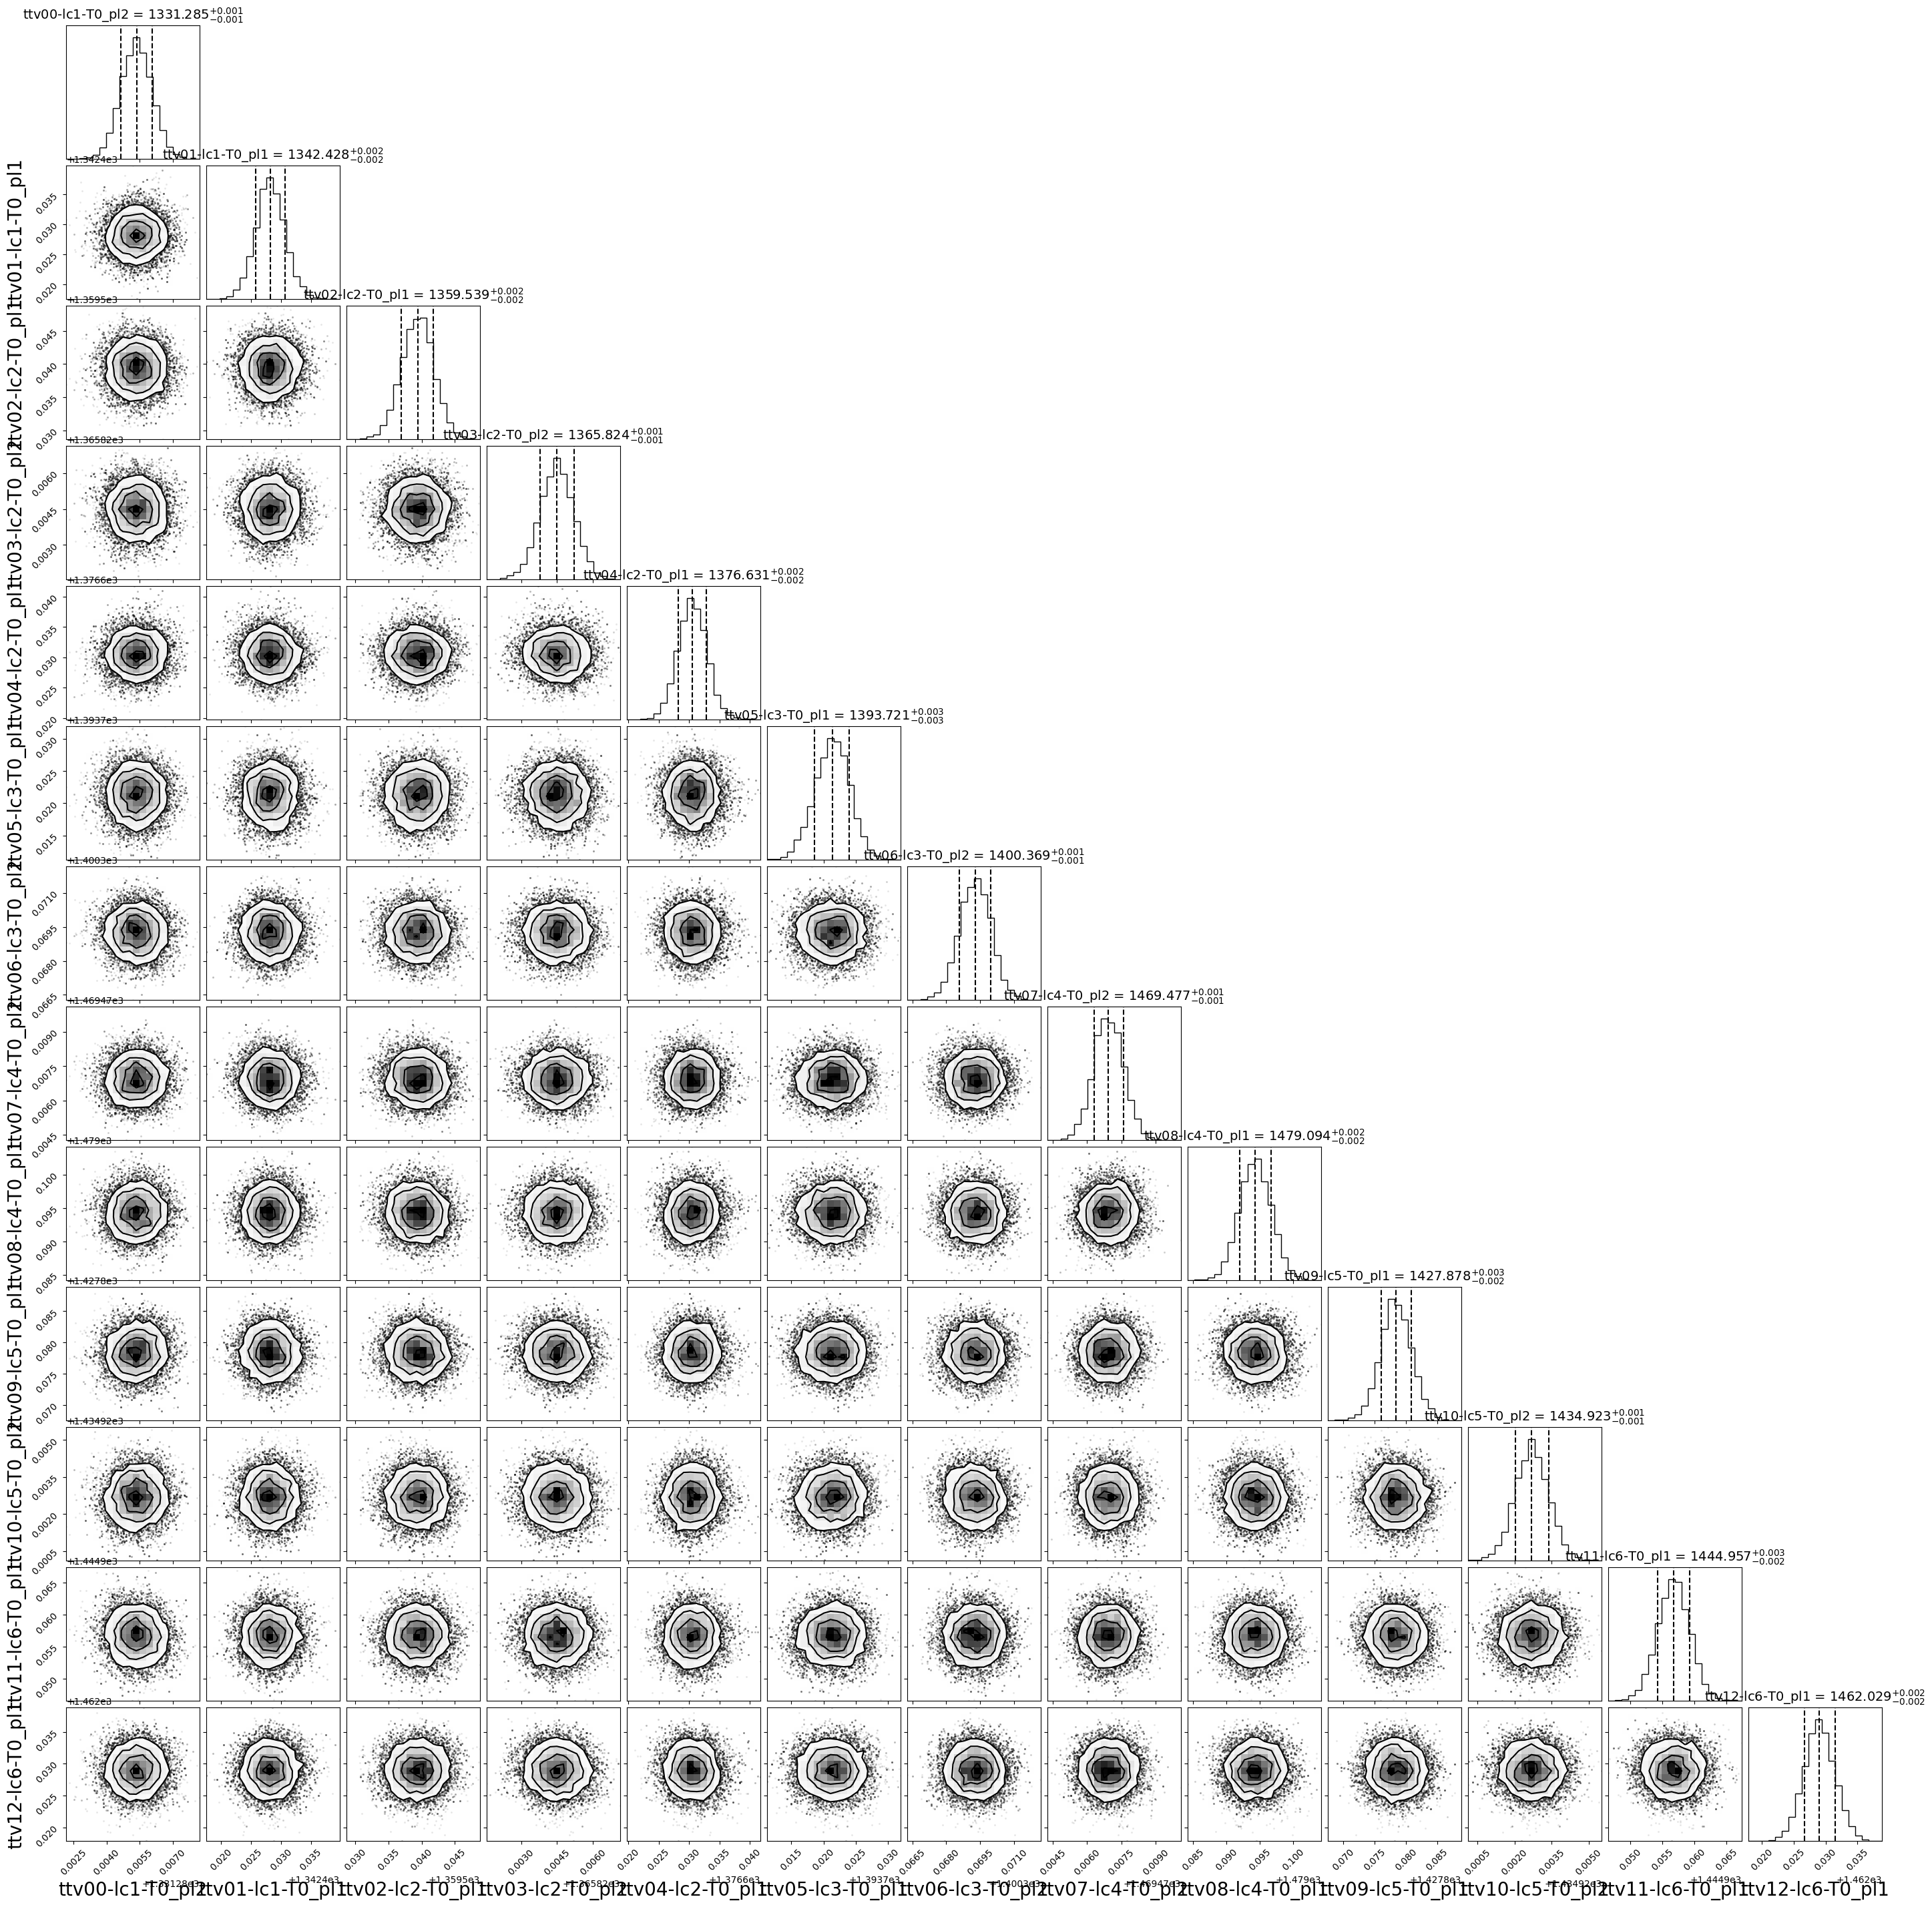

In [ ]:
#cornerplot of T0s
fig = result.plot_corner(pars = all_T0_names);

In [32]:
#extract ttv values for planet 1

{k:v for k,v in params_dict.items() if f'T0_pl1' in k}

{'ttv01-lc1-T0_pl1': 1342.4281946095093+/-0.0024361019883372137,
 'ttv02-lc2-T0_pl1': 1359.5394262797838+/-0.0024319350051200672,
 'ttv04-lc2-T0_pl1': 1376.630536387638+/-0.002353434384758657,
 'ttv05-lc3-T0_pl1': 1393.7214028843155+/-0.002681758582752991,
 'ttv08-lc4-T0_pl1': 1479.094324828132+/-0.002385498113653739,
 'ttv09-lc5-T0_pl1': 1427.8784160519003+/-0.002466846340325901,
 'ttv11-lc6-T0_pl1': 1444.9567796400843+/-0.002506038005321898,
 'ttv12-lc6-T0_pl1': 1462.029002832283+/-0.0024252965312143715}